Aquí lo que vamos a presentar, es una visualización de los vectores de caraterisiticas que estamos generan con la red, donde mostramos el conjunto de entrenamiento como una muestra de las regiones y el conjunto de evaluacion, donde esta clasificando estas imagenes en que region.

- El objetivo de esta visualizacion es, dar una idea de que tanto cambian las representaciones de nuestro conjunto.


In [12]:
from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [13]:
batch_size = 32
device = "cuda"

In [6]:
data_dir = "../data" 
# Conjunto de datos CIFAR10
train_data = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
eval_data = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size, shuffle=True)

print("Se cargaron los datos correctamente")

Files already downloaded and verified
Files already downloaded and verified
Se cargaron los datos correctamente


In [14]:
class First_CNN(nn.Module):
    def __init__(self):           
        super(First_CNN, self).__init__()
        self.conv1 = nn.Sequential( # input shape (3, 32, 32)
        nn.Conv2d(
        in_channels=3, # input height
        out_channels=16, # n_filters
        kernel_size=5, # filter size
        stride=1, # filter movement/step
        padding=2,
        # if want same width and length of this image after con2d,
        #padding=(kernel_size-1)/2 if stride=1
        ), # output shape (16, 16, 16)
        nn.ReLU(), # activation
        nn.MaxPool2d(kernel_size=2),
        # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential( # input shape (16, 14, 14)
        nn.Conv2d(16, 32, 5, 1, 2), # output shape (32, 8, 8)
        nn.ReLU(), # activation
        nn.MaxPool2d(2), # output shape (32, 7, 7)
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32 *8 *8, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        # flatten the output of conv2 to (batch_size, 32 * 8 * 8)
        output = self.linear_relu_stack(x)
        return output



In [10]:
def extractor(dataloader, model):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Obtener las características (vectores de características) del modelo
            features = model(X)
            all_features.append(features.cpu())
            all_labels.append(y.cpu())

    # Concatenar todas las características y etiquetas
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_features, all_labels


## Modelo Etapa 1

Vamos a visualizar si los datos todos los datos, para ver si realiza una agrupación o se superponen los datos.

In [10]:
fase_1 = torch.load("Fase_1.pth")
# Quitamos el clasificador
del fase_1["linear_relu_stack.4.weight"]
del fase_1["linear_relu_stack.4.bias"]

In [11]:
model = First_CNN().to(device)
model.load_state_dict(fase_1)

<All keys matched successfully>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.009s...
[t-SNE] Computed neighbors for 50000 samples in 34.995s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

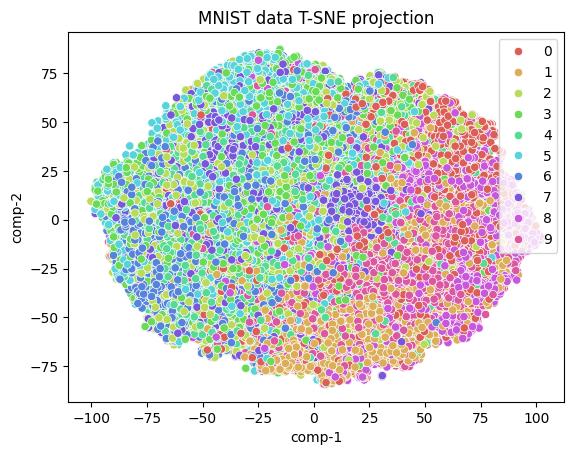

In [12]:
from pprint import pprint

features, labels = extractor(train_dataloader, model)

# Usar t-SNE para reducir las dimensiones a 2
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features)

# Crear un DataFrame para la visualización con seaborn
df = pd.DataFrame()
df["y"] = labels.tolist()
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

# Visualizar con seaborn
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection")


classes = {0:'avión', 1:'automóvil', 2:'pájaro', 3:'gato',
           4:'ciervo', 5:'perro', 6:'rana', 7:'caballo', 8:'barco', 9:'camión'}
pprint(classes)



In [13]:
# Separar las clases 0-4 y 5-9 para los conjuntos de entrenamiento y evaluación
# Conjunto de entrenamiento
train_indices_0_to_4 = [i for i in range(len(train_data)) if train_data.targets[i] < 5]
train_indices_5_to_9 = [i for i in range(len(train_data)) if train_data.targets[i] >= 5]

train_0_to_4 = torch.utils.data.Subset(train_data, train_indices_0_to_4)
train_5_to_9 = torch.utils.data.Subset(train_data, train_indices_5_to_9)


train_0_to_4_dataloader = DataLoader(train_0_to_4, batch_size=batch_size, shuffle=True)
train_5_to_9_dataloader = DataLoader(train_5_to_9, batch_size=batch_size, shuffle=True)


In [15]:
classes = {0:'avión', 1:'automóvil', 2:'pájaro', 3:'gato',
           4:'ciervo', 5:'perro', 6:'rana', 7:'caballo', 8:'barco', 9:'camión'}
pprint(classes)

{0: 'avión',
 1: 'automóvil',
 2: 'pájaro',
 3: 'gato',
 4: 'ciervo',
 5: 'perro',
 6: 'rana',
 7: 'caballo',
 8: 'barco',
 9: 'camión'}


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.005s...
[t-SNE] Computed neighbors for 25000 samples in 8.988s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sam

[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

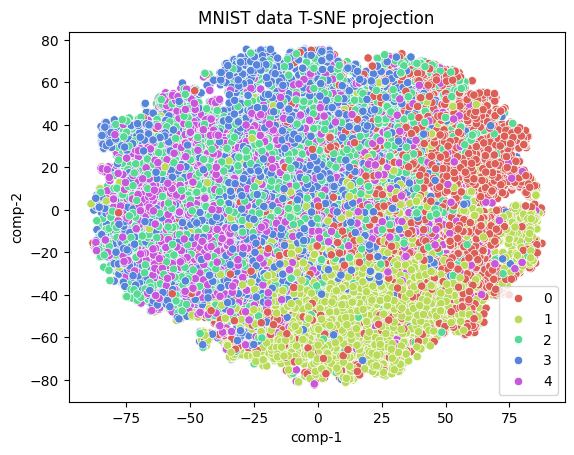

In [17]:
from pprint import pprint

features, labels = extractor(train_0_to_4_dataloader, model)

# Usar t-SNE para reducir las dimensiones a 2
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features)

# Crear un DataFrame para la visualización con seaborn
df = pd.DataFrame()
df["y"] = labels.tolist()
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

# Visualizar con seaborn
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="MNIST data T-SNE projection")



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.005s...
[t-SNE] Computed neighbors for 25000 samples in 8.748s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sam

[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

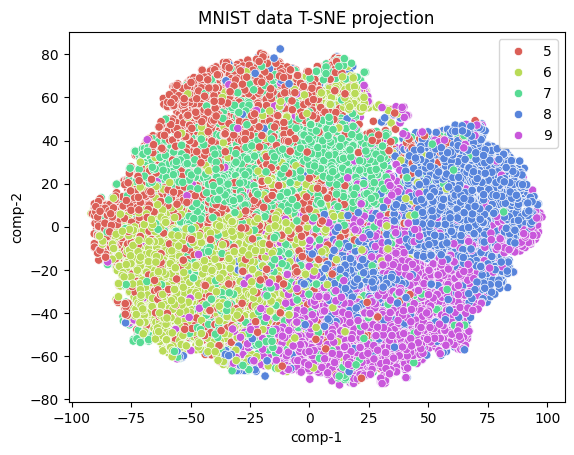

In [18]:
from pprint import pprint

features, labels = extractor(train_5_to_9_dataloader, model)

# Usar t-SNE para reducir las dimensiones a 2
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features)

# Crear un DataFrame para la visualización con seaborn
df = pd.DataFrame()
df["y"] = labels.tolist()
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

# Visualizar con seaborn
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="MNIST data T-SNE projection")




### Modelo Completo

In [6]:
import torchvision
from torchvision import transforms
import torch

In [7]:
# Transformaciones para preprocesar los datos
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Descarga y carga el conjunto de datos CIFAR-10
train_data = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)


Files already downloaded and verified


In [15]:
total = torch.load("Total.pth")
# Quitamos el clasificador
del total["linear_relu_stack.4.weight"]
del total["linear_relu_stack.4.bias"]

model = First_CNN().to(device)
model.load_state_dict(total)

<All keys matched successfully>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.009s...
[t-SNE] Computed neighbors for 50000 samples in 33.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

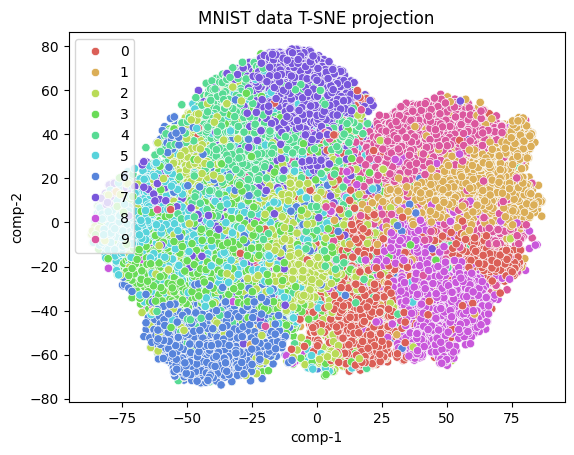

In [16]:
from pprint import pprint

features, labels = extractor(train_dataloader, model)

# Usar t-SNE para reducir las dimensiones a 2
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features)

# Crear un DataFrame para la visualización con seaborn
df = pd.DataFrame()
df["y"] = labels.tolist()
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

# Visualizar con seaborn
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection")


classes = {0:'avión', 1:'automóvil', 2:'pájaro', 3:'gato',
           4:'ciervo', 5:'perro', 6:'rana', 7:'caballo', 8:'barco', 9:'camión'}
pprint(classes)

